In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import babet as bb
from moarpalettes import get_palette
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
from cmcrameri import cm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
color_palette = get_palette.Petroff6().to_sn_palette()
color_palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294),
 (0.5882352941176471, 0.2901960784313726, 0.5450980392156862),
 (0.611764705882353, 0.611764705882353, 0.6313725490196078),
 (0.47843137254901963, 0.12941176470588237, 0.8666666666666667)]

In [ ]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 10, 45, 65] # longitude min, longitude max, latitude min, latitude max
northsea = [-17, 20, 40, 70]

# Load data

In [139]:
# ERA5 analogues

# check if file exists
if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues_72hour_mean.nc'):
    # precip
    tmp1 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/anaologues_tp_past.nc').expand_dims(climate=["1950"])
    tmp2 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/anaologues_tp_prst.nc').expand_dims(climate=["present"])

    tmp = xr.concat([tmp1, tmp2], dim="climate")

    # Find all variables that start with "unknown"
    precip_vars = sorted([var for var in tmp.data_vars if var.startswith("unknown")])

    # Stack all precipitation variables along the new 'member' dimension
    tp = xr.concat([tmp[var] for var in precip_vars], dim="member")

    # Assign member values from 1 to 27
    tp = tp.assign_coords(member=np.arange(1, len(precip_vars) + 1))

    # Create a new dataset with the combined variable
    era5_analogues = xr.Dataset({"tp": tp}, coords={"lat": tmp.lat, "lon": tmp.lon, "member": tp.member})


    # mean sea level pressure
    tmp1 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/anaologues_slp_past.nc').expand_dims(climate=["1950"])
    tmp2 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/anaologues_slp_prst.nc').expand_dims(climate=["present"])

    tmp = xr.concat([tmp1, tmp2], dim="climate")

    # Find all variables that start with "unknown"
    slp_vars = sorted([var for var in tmp.data_vars if var.startswith("msl")])

    # Stack all precipitation variables along the new 'member' dimension
    msl = xr.concat([tmp[var] for var in slp_vars], dim="member")

    # Assign member values from 1 to 27
    msl = msl.assign_coords(member=np.arange(1, len(slp_vars) + 1))

    # Create a new dataset with the combined variable
    era5_analogues = xr.merge([era5_analogues,
                               xr.Dataset({"msl": msl}, coords={"lat": tmp.lat, "lon": tmp.lon, "member": msl.member})], compat="override")

    # 2m temperature
    tmp1 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/anaologues_t2m_past.nc').expand_dims(climate=["1950"])
    tmp2 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/anaologues_t2m_prst.nc').expand_dims(climate=["present"])

    tmp = xr.concat([tmp1, tmp2], dim="climate")

    # Find all variables that start with "unknown"
    t2m_vars = sorted([var for var in tmp.data_vars if var.startswith("unknown")])

    # Stack all precipitation variables along the new 'member' dimension
    t2m = xr.concat([tmp[var] for var in t2m_vars], dim="member")

    # Assign member values from 1 to 27
    t2m = t2m.assign_coords(member=np.arange(1, len(t2m_vars) + 1))

    # Create a new dataset with the combined variable
    era5_analogues = xr.merge([era5_analogues,
                               xr.Dataset({"t2m": t2m}, coords={"lat": tmp.lat, "lon": tmp.lon, "member": t2m.member})], compat="override")

    # Save to netcdf
    era5_analogues.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues_72hour_mean.nc')
else:
    print('Importing data from pre-existing file')
    era5_analogues = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues_72hour_mean.nc')

Importing data from pre-existing file


In [141]:
# RACMO analogues

In [142]:
# PGW
# check if file exists
if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_clean.nc'):
    # mean sea level pressure
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_slp_past.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_slp_prst.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_slp_fut1.nc').expand_dims(climate=["future1"])
    tmp4 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_slp_fut2.nc').expand_dims(climate=["future2"])
    tmp = xr.concat([tmp1, tmp2, tmp3, tmp4], dim="climate").rename({"unknown": "msl"})

    ds = xr.Dataset(
        data_vars=dict(
            msl=(["climate", "time", "lat", "lon"], tmp.msl.values)),
        coords=dict(
            lon=tmp.lon.values[0,:],
            lat=tmp.lat.values[:,0],
            time=tmp.time.values,
            climate=tmp.climate.values),
        attrs=dict(description="PGW data"))

    # precip
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_tp_past.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_tp_prst.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_tp_fut1.nc').expand_dims(climate=["future1"])
    tmp4 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_tp_fut2.nc').expand_dims(climate=["future2"])
    tmp = xr.concat([tmp1, tmp2, tmp3, tmp4], dim="climate").rename({"unknown": "tp"})

    ds = xr.merge([ds,
                    xr.Dataset(data_vars=dict(tp=(["climate", "time", "lat", "lon"], tmp.tp.values)),
                               coords=dict(lon=tmp.lon.values[0,:],
                                    lat=tmp.lat.values[:,0],
                                    time=tmp.time.values,
                                    climate=tmp.climate.values),
                            attrs=dict(description="PGW data"))], compat="override")

    # temperature
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_t2m_past.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_t2m_prst.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_t2m_fut1.nc').expand_dims(climate=["future1"])
    tmp4 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_t2m_fut2.nc').expand_dims(climate=["future2"])
    tmp = xr.concat([tmp1, tmp2, tmp3, tmp4], dim="climate").rename({"unknown": "t2m"})
    ds = xr.merge([ds,
                    xr.Dataset(data_vars=dict(t2m=(["climate", "time", "lat", "lon"], tmp.t2m.values)),
                               coords=dict(lon=tmp.lon.values[0,:],
                                    lat=tmp.lat.values[:,0],
                                    time=tmp.time.values,
                                    climate=tmp.climate.values),
                            attrs=dict(description="PGW data"))], 
                    compat="override")

    # Save to netcdf
    ds.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_clean.nc')
else:
    print('Importing data from pre-existing file')
    pgw = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_clean.nc')

Importing data from pre-existing file


In [144]:
def accum2rate(ds):
    """
    Function to convert accumulated variables to conventional ones.
    Definition to convert accumulated variables to instantaneous.
    Written by Nick Leach.

    Input:
    ------

    Output:
    -------
    """

    ds = ds.copy()
    oindex = ds.time
    inidate = pd.to_datetime(oindex[0].values)
    ds = ds.diff('time') / (ds.time.diff('time').astype(float) / 1e9 )
    ds = ds.reindex(time=oindex)
    return ds[1:]

def preproc_ds_v2(ds):
    """
    Main pre-processing function
    Writtten by Nick Leach and Shirin Ermis.

    Input:
    ------
    ds: xarray dataset

    Output:
    -------
    ds1: xarray dataset with inidate dimension added
    """
    # remove any dimensions of length 1
    ds1 = ds.squeeze()
    # set up aux data
    inidate = pd.to_datetime(ds1.time[0].values)
    # expand dimensions to include extra info
    if not 'inidate' in ds1:
        ds1 = ds1.expand_dims({'inidate': [inidate]}).copy()

    if not 'number' in ds1:
        ds1 = ds1.expand_dims({'number': [0]}).copy()

    # put time dimension at front
    ds1 = ds1.transpose('time', ...)
    return ds1

def get_ifs_data(experiments=['pi', 'pi_1950', 'curr', 'incr'], base_dir='/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/'):
    """
    Function to read in IFS data
    """
    tmp = []
    exp = 'curr'
    for i, cf in enumerate(['cf', 'pf']):
        file_dir = os.path.join(base_dir, cf)
        tmp.append(xr.open_mfdataset(os.path.join(file_dir.format(exp), '*.nc'), engine='netcdf4', preprocess=preproc_ds_v2).get(['tp', 't2m', 'msl']))
    return xr.concat(tmp, dim='number')



In [145]:
# FBA IFS
tmp = []
base_dir='/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
climates = ['1870', '1950', 'present', 'future1']
for e, exp in enumerate(['pi', 'pi_1950', 'curr', 'incr']):
    # print(os.path.join(base_dir.format(exp), '*.nc'))
    tmp.append(xr.open_mfdataset(os.path.join(base_dir.format(exp), '*.nc'), engine='netcdf4', preprocess=preproc_ds_v2).expand_dims(climate=[climates[e]]))
ifs = xr.concat(tmp, dim='climate')

In [146]:
# FBA ACCESS

# check if file exists
if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_clean.nc'):
    # precip
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_pr_highGHG.nc').expand_dims(climate=["future1"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_pr_lowGHG.nc').expand_dims(climate=["1870"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_pr_ctrl.nc').expand_dims(climate=["present"])
    ds = xr.concat([tmp1, tmp2, tmp3], dim="climate").rename({"pr": "tp"})

    # temperature
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_tas_highGHG.nc').expand_dims(climate=["future1"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_tas_lowGHG.nc').expand_dims(climate=["1870"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_tas_ctrl.nc').expand_dims(climate=["present"])
    ds = xr.merge([ds, xr.concat([tmp1, tmp2, tmp3], dim="climate")], compat="override")

    # mean sea level pressure
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_psl_highGHG.nc').expand_dims(climate=["future1"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_psl_lowGHG.nc').expand_dims(climate=["1870"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_psl_ctrl.nc').expand_dims(climate=["present"])
    ds = xr.merge([ds, xr.concat([tmp1, tmp2, tmp3], dim="climate").rename({'psl': 'msl'})], compat="override")

    # Save to netcdf
    ds.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_clean.nc')
else:
    print('Importing data from pre-existing file')
    micas = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_clean.nc')

Importing data from pre-existing file


# Data processing

Note that the order that the map extents have to be given to the ```.sel``` function differ from dataset to dataset. You will notice immediately if something is off becausde you will end up with only nans if you do it wrong.

In [147]:
# ERA5 analogues
era5_analogues['tp'] = era5_analogues['tp'].sel(lat=slice(uk[3], uk[2]), lon=slice(uk[0], uk[1]))
era5_analogues['msl'] = era5_analogues['msl'].sel(lat=slice(uk[3], uk[2]), lon=slice(uk[0], uk[1]))/100

In [148]:
# RACMO analogues

In [149]:
# PGW
pgw['tp'] = (((pgw.tp.sel(time=slice('2023-10-19 00', '2023-10-22 00'))*3*3600).sum(dim='time'))/1e5).sel(lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1]))
pgw['msl'] = (pgw.msl.sel(time='2023-10-20 00', lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).squeeze())/100

In [150]:
# FBA IFS
ifs['tp'] = ((ifs.tp.sel(time='2023-10-22 00') - ifs.tp.sel(time='2023-10-19 00'))*1000).sel(latitude=slice(uk[3], uk[2]), longitude=slice(uk[0], uk[1]))
ifs['msl'] = ifs.msl.sel(time=slice('2023-10-19 00', '2023-10-22 00'), latitude=slice(uk[3], uk[2]), longitude=slice(uk[0], uk[1])).mean(dim='time')/100

In [151]:
# ACCESS MICAS
micas['tp'] = micas.tp.sel(time=slice('2023-10-19 12', '2023-10-21 12'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).sum(dim='time')*24*3600
micas['msl'] = micas.msl.sel(time=slice('2023-10-19 12', '2023-10-21 12'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).mean(dim='time')/100

# Map plot

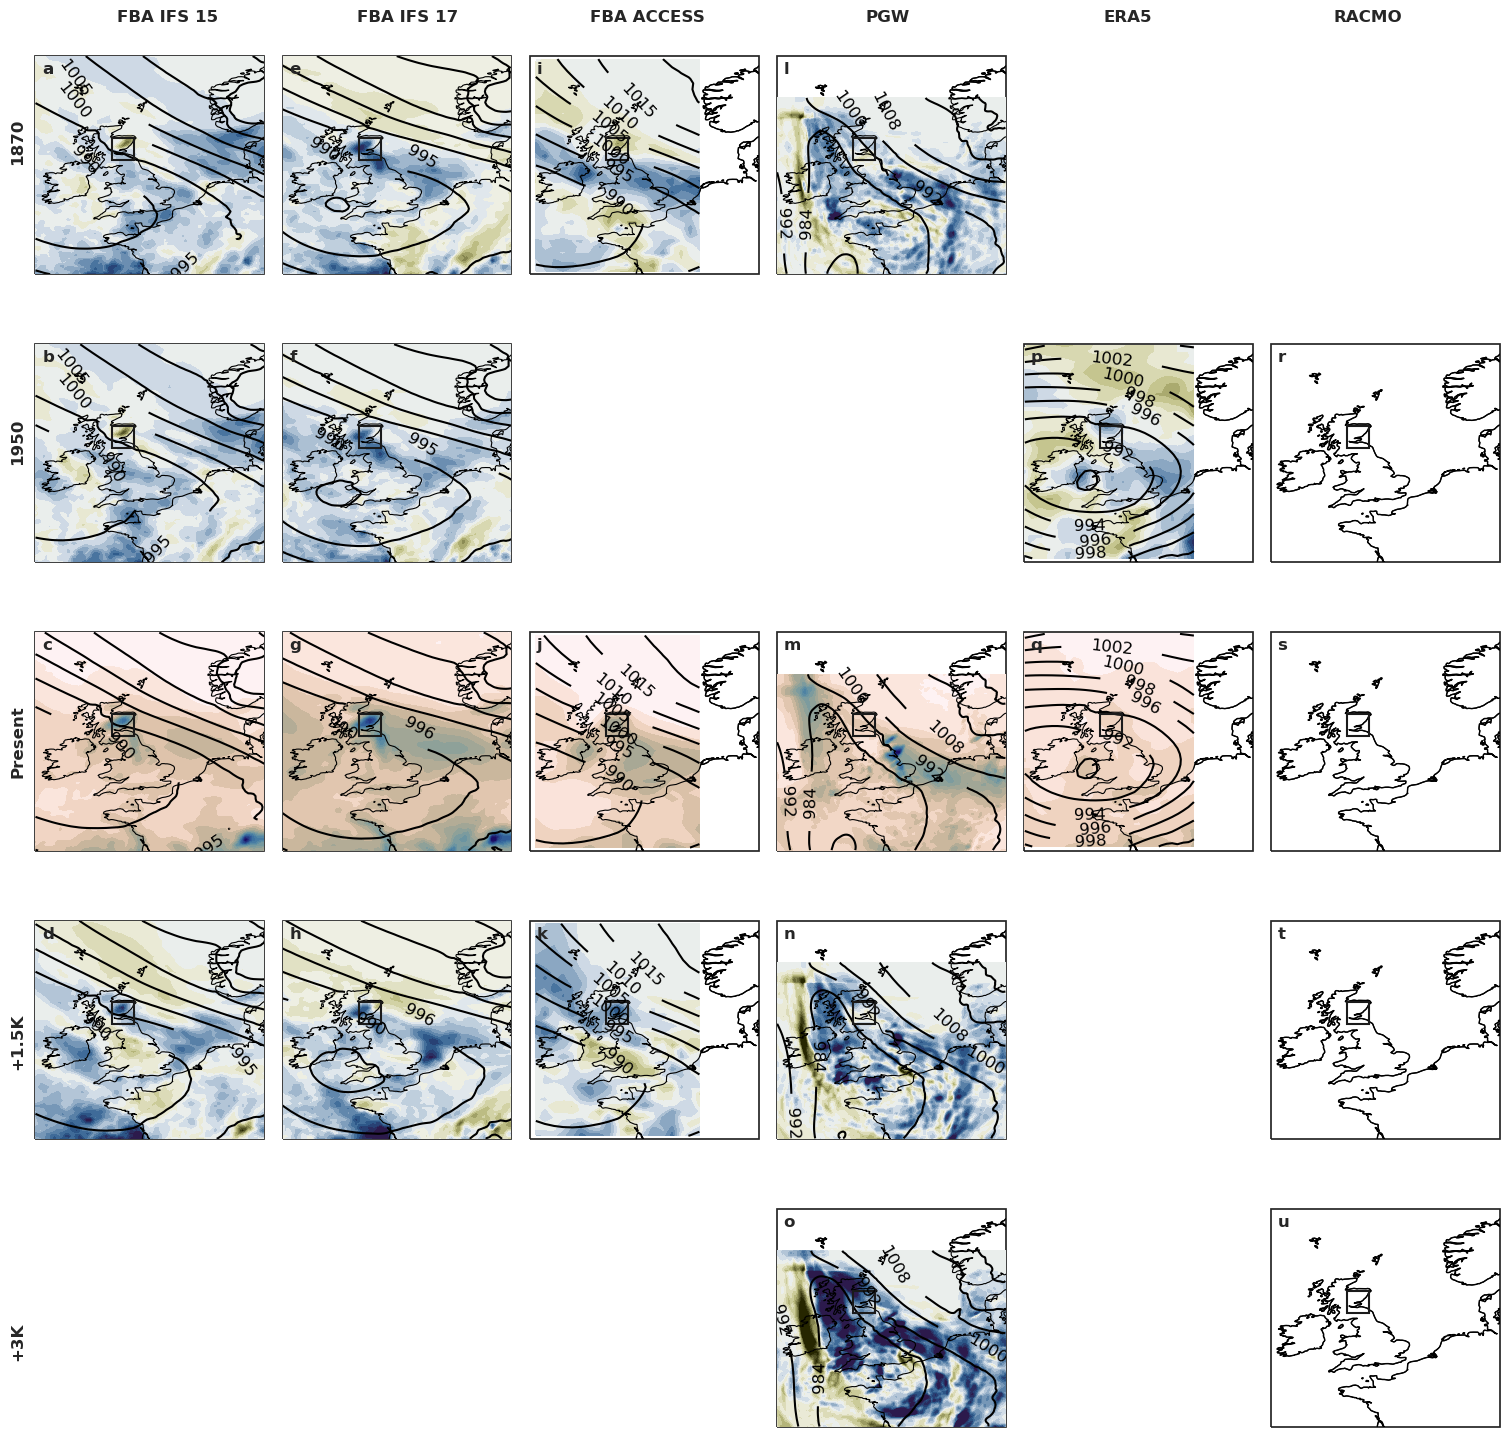

In [154]:
# Create figure with two subplots side by side
fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
projection = ccrs.PlateCarree()

# difference range
pr_diff = 15
pr_full = 150

# Define column headers
column_headers = ["FBA IFS 15", "FBA IFS 17", "FBA ACCESS", "PGW", "ERA5", "RACMO"]

# FBA IFS 15 --------------

# 1870
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1870")).sel(inidate='2023-10-15').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r, vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 0], add_colorbar=False, transform=projection
)
cs = axes[0,0].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='1870').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# 1950
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1950")).sel(inidate='2023-10-15').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r, vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 0], add_colorbar=False, transform=projection
)
cs = axes[1,0].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='1950').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# present
(ifs.tp.sel(climate="present")).sel(inidate='2023-10-15').mean('number').squeeze().plot.contourf(
    cmap=cm.lapaz_r, vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 0], add_colorbar=False, transform=projection
)
cs = axes[2,0].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='present').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(ifs.tp.sel(climate="future1") - ifs.tp.sel(climate="present")).sel(inidate='2023-10-15').squeeze().mean('number').plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 0], add_colorbar=False, transform=projection
)
cs = axes[3,0].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='future1').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[4,0].axis('off')

# FBA IFS 17 --------------

# 1870
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1870")).sel(inidate='2023-10-17').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 1], add_colorbar=False, transform=projection
)
cs = axes[0,1].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='1870').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# 1950
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1950")).sel(inidate='2023-10-17').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 1], add_colorbar=False, transform=projection
)
cs = axes[1,1].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='1950').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# present
(ifs.tp.sel(climate="present")).sel(inidate='2023-10-17').mean('number').squeeze().plot.contourf(
    cmap=cm.lapaz_r, vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 1], add_colorbar=False, transform=projection
)
cs = axes[2,1].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='present').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(ifs.tp.sel(climate="future1") - ifs.tp.sel(climate="present")).sel(inidate='2023-10-17').squeeze().mean('number').plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 1], add_colorbar=False, transform=projection
)
cs = axes[3,1].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='future1').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[4,1].axis('off')

# FBA ACCESS --------------

# 1870
(micas.tp.sel(climate="present") - micas.tp.sel(climate="1870")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 2], add_colorbar=False, transform=projection
)
cs = axes[0,2].contour(micas.lon.values, micas.lat.values,micas.msl.sel(climate='1870').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# present
(micas.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 2], add_colorbar=False, transform=projection
)
cs = axes[2,2].contour(micas.lon.values, micas.lat.values,micas.msl.sel(climate='present').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(micas.tp.sel(climate="future1") - micas.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 2], add_colorbar=False, transform=projection
)
cs = axes[3,2].contour(micas.lon.values, micas.lat.values,micas.msl.sel(climate='future1').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')

axes[1,2].axis('off')
axes[4,2].axis('off')

# PGW ---------------------

# 1870
(pgw.tp.sel(climate="present") - pgw.tp.sel(climate="1870")).squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 3], add_colorbar=False, transform=projection
)
cs = axes[0,3].contour(pgw.lon.values, pgw.lat.values,pgw.msl.sel(climate='1870').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# present
(pgw.tp.sel(climate="present")).squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 3], add_colorbar=False, transform=projection
)
cs = axes[2,3].contour(pgw.lon.values, pgw.lat.values,pgw.msl.sel(climate='present').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(pgw.tp.sel(climate="future1") - pgw.tp.sel(climate="present")).squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 3], add_colorbar=False, transform=projection
)
cs = axes[3,3].contour(pgw.lon.values, pgw.lat.values,pgw.msl.sel(climate='future1').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(pgw.tp.sel(climate="future2") - pgw.tp.sel(climate="present")).squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[4, 3], add_colorbar=False, transform=projection
)
cs = axes[4,3].contour(pgw.lon.values, pgw.lat.values,pgw.msl.sel(climate='future2').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')

axes[1,3].axis('off')

# ERA5 --------------------

# 1950
(era5_analogues.tp.sel(climate="present") - era5_analogues.tp.sel(climate="1950")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 4], add_colorbar=False, transform=projection
)
cs = axes[1,4].contour(era5_analogues.lon.values, era5_analogues.lat.values,era5_analogues.msl.sel(climate='1950').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# present
(era5_analogues.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 4], add_colorbar=False, transform=projection
)
cs = axes[2,4].contour(era5_analogues.lon.values, era5_analogues.lat.values,era5_analogues.msl.sel(climate='1950').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,4].axis('off')
axes[3,4].axis('off')
axes[4,4].axis('off')

# Make ERA5 current plot stand out
# axes[2,4].outline_patch.set_linewidth(3)  # Make frame bold
# axes[2,4].outline_patch.set_edgecolor(color_palette[2])  # Set frame color to red

# RACMO -------------------

axes[0,5].axis('off')


# Figure settings ----------

labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u']
axes_with_data = [axes[0,0], axes[1,0], axes[2,0], axes[3,0], # FBA IFS 15
                  axes[0,1], axes[1,1], axes[2,1], axes[3,1], # FBA IFS 17
                  axes[0,2], axes[2,2], axes[3,2], # FBA ACCESS
                  axes[0,3], axes[2,3], axes[3,3], axes[4,3], # PGW
                  axes[1,4], axes[2,4], # ERA5
                  axes[1,5], axes[2,5], axes[3,5], axes[4,5], # RACMO

]

# Apply Cartopy settings to both axes
for ax, label in zip(axes_with_data, labels):
    ax.set_extent(uk, crs=ccrs.PlateCarree())  # Set map extent
    if ax in []:
        ax.add_feature(cfeature.COASTLINE, edgecolor='grey', linewidth=0.8, zorder = 14)  # Add land borders
    else:
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.8, zorder = 14)  # Add land borders
    ax.coastlines()  # Add coastlines
    ax.text(0.03, 0.92, label, transform=ax.transAxes, fontsize=12, fontweight="bold", zorder=20)

    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=1.5, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax.add_patch(rectangle)
    rectangle.set_zorder(17)

# Add column headers
col_locs = np.linspace(0.1, 0.9, len(column_headers))
for col_idx, col_name in enumerate(column_headers):
    fig.text(col_locs[col_idx], 0.98, col_name, fontsize=12, ha='center',  fontweight='bold')

# Define row headers
row_headers = ["1870", "1950", "Present", "+1.5K", "+3K"]

# Add row headers rotated by 90 degrees
for i, label in enumerate(row_headers):
    fig.text(0.00, 1 - (i + 0.5) / 5, label, va='center', ha='center', 
             fontsize=12, rotation=90, fontweight='bold')

plt.tight_layout()

In [43]:
uk = [-11, 10, 45, 65] # longitude min, longitude max, latitude min, latitude max

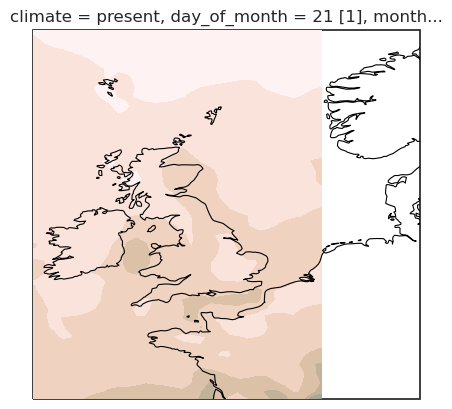

In [44]:
fig, ax = plt.subplots(1,1,figsize=(5, 5),  subplot_kw={'projection': ccrs.PlateCarree()})

(era5_analogues.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    levels=20, ax=ax, add_colorbar=False, transform=projection
)
ax.set_extent(uk, crs=ccrs.PlateCarree())  # Set map extent
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.8, zorder = 14)  # Add land borders

In [113]:
micas.msl

<xarray.DataArray 'msl' (climate: 3, member: 33, lat: 46, lon: 36)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat      (lat) float32 42.5 43.06 43.61 44.17 ... 65.83 66.39 66.94 67.5
  * lon      (lon) float32 -24.58 -23.75 -22.92 -22.08 ... 2.917 3.75 4.583
  * climate  (climate) object 'future1' '1870' 'present'
Dimensions without coordinates: member